# SI <font color='red'>YA ESTA GUARDADO</font> EL TERRENO CON SDF

## Leer el dataframe guardado

In [1]:
import pandas as pd
dataframe = pd.read_csv('./files/warped_terrain_sdf.csv')

In [2]:
dataframe

,x,y,z,density,distance
0,0.00,0.00,0.00,0.000000,0.070711
1,0.00,0.00,0.05,0.032586,0.050000
2,0.00,0.00,0.10,0.061833,-0.050000
3,0.00,0.00,0.15,0.082446,-0.100000
4,0.00,0.00,0.20,0.097867,-0.150000
...,...,...,...,...,...
7995,0.95,0.95,0.75,0.377797,0.860233
7996,0.95,0.95,0.80,0.366430,0.890225
7997,0.95,0.95,0.85,0.352210,0.921954
7998,0.95,0.95,0.90,0.334525,0.955249


### AHORA PODES PASAR  <font color='orange'>DIRECTO AL PASO 5 </font>

# SI <font color='red'>NO ESTA GUARDADO</font> EL TERRENO CON SDF EN UN ARCHIVO
Tenes que correr todo este archivo desde el paso 1

# 1. Generacion de cubo de tierra (datos)

In [1]:
!pip install noise

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [65]:
import numpy as np
import noise
import pandas as pd
def generate_terrain(x: int, y: int, z: int):
    print("generate_3D_terrain")
    shape = (x, y, z)
    scale = 100.0
    octaves = 6
    persistence = 0.5
    lacunarity = 2.0

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                density = noise.pnoise3(i / scale,
                                        j / scale,
                                        k / scale,
                                        octaves=octaves,
                                        persistence=persistence,
                                        lacunarity=lacunarity,
                                        repeatx=1024,
                                        repeaty=1024,
                                        repeatz=1024,
                                        base=42)
                terrain[i][j][k] = density
                
                
    return terrain

In [66]:
import numpy as np

'''Terrain with rows of density'''
def generate_striped_terrain(x: int, y: int, z: int):
    shape = (x, y, z)
    scale = 2.0
    octaves = 6
    persistence = 0.5
    lacunarity = 2.0

    world = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                density = i
                world[i][j][k] = density

    return world

In [67]:
terrain = generate_terrain(20,20,20)

generate_3D_terrain


In [68]:
import matplotlib.pyplot as plt
def plot_3D(dataframe: np.ndarray, density) -> None:
    print("plot_3D")
    x = np.arange(dataframe.shape[0])[:, None, None]
    y = np.arange(dataframe.shape[1])[None, :, None]
    z = np.arange(dataframe.shape[2])[None, None, :]
    x, y, z = np.broadcast_arrays(x, y, z)

    # Creating figure fig = plt.figure(figsize=(20, 13))
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)

    # Creating plot
    sctt = ax.scatter3D(x, y, z, alpha=0.8, c=density, cmap='terrain', marker='o')

    plt.title("Terrain plot")
    ax.set_xlabel('X-axis', fontweight='bold')
    ax.set_ylabel('Y-axis', fontweight='bold')
    ax.set_zlabel('Z-axis', fontweight='bold')
    fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)

    # show plot
    plt.show()

plot_3D


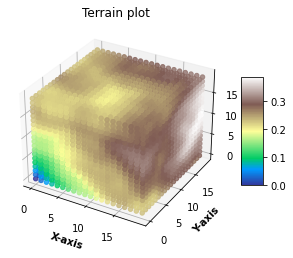

In [69]:
plot_3D(terrain, terrain.ravel())

# 2. Funcion para pasar de matriz a dataframe

In [70]:
import pandas as pd
def using_multiindex(A, columns):
    scale = 0.05
    shape = A.shape
    index = pd.MultiIndex.from_product([list(map(lambda number: number * scale, range(s))) for s in shape], names=columns)
    df = pd.DataFrame(index=index).reset_index()
    df['density'] = A.ravel()
    return df

In [71]:
dataframe_terrain = using_multiindex(terrain, list('xyz'))

plot_3D


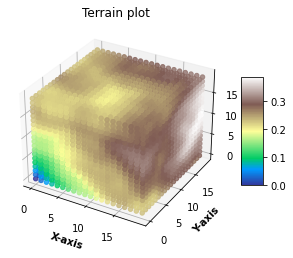

In [72]:
plot_3D(terrain, dataframe_terrain['density'])

In [73]:
np.array(dataframe_terrain['density'])

array([0.        , 0.03258603, 0.0618329 , ..., 0.35220993, 0.33452544,
       0.30899072])

In [74]:
terrain.ravel()

array([0.        , 0.03258603, 0.0618329 , ..., 0.35220993, 0.33452544,
       0.30899072])

In [75]:
dataframe_terrain

,x,y,z,density
0,0.00,0.00,0.00,0.000000
1,0.00,0.00,0.05,0.032586
2,0.00,0.00,0.10,0.061833
3,0.00,0.00,0.15,0.082446
4,0.00,0.00,0.20,0.097867
...,...,...,...,...
7995,0.95,0.95,0.75,0.377797
7996,0.95,0.95,0.80,0.366430
7997,0.95,0.95,0.85,0.352210
7998,0.95,0.95,0.90,0.334525


In [76]:
dataframe_terrain.iloc[1050]

x          0.100000
y          0.600000
z          0.500000
density    0.223966
Name: 1050, dtype: float64

In [77]:
terrain[2][12][10]

0.22396598756313324

# 3. Dataframe a SDF

In [78]:
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


def getDistance(x, y, z, realInternalValue, internalValue = [0,1], columns = ['x','y','z','lineid']):
    coords = dataframe[columns]
    #print("internalValue: {} - realInternalValue: {}".format(internalValue, realInternalValue))
    
    realInternalValueIsAnInternalValue = internalValue[0] <= realInternalValue <= internalValue[1]
    #print(realInternalValueIsAnInternalValue)
    if realInternalValueIsAnInternalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[~coords[columns[3]].between(internalValue[0], internalValue[1])]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords[columns[3]].between(internalValue[0], internalValue[1])]
    
    distances = coords.apply(lambda row: distanceSquared3D((x,y,z),(float(row[columns[0]]), float(row[columns[1]]), float(row[columns[2]]))), axis=1)
       
    min_distance = distances.min()
    if realInternalValueIsAnInternalValue:
        return -(min_distance)
    
    #print(min_distance)
    return min_distance
        
    
def dataframe_to_sdf(dataframe, internalValue = [0,1], columns = ['x','y','z','lineid']): #columns = [x, y, z, faultid, lineid]
    dataframe["distance"] = dataframe.apply(lambda x: getDistance(x[columns[0]], x[columns[1]], x[columns[2]], x[columns[3]], internalValue, columns), axis=1)
    return dataframe

In [79]:
#obtengo la densidad de uno de los puntos
dataframe_terrain.iloc[1].density

0.032586026936769485

In [80]:
internalValue = [0.05,0.15]

In [81]:
import time

initial_time=time.time()
 #dataframe_terrain.iloc[1].density
columns = ['x','y', 'z', 'density']
dataframe = dataframe_terrain
sdf = dataframe_to_sdf(dataframe_terrain, internalValue, columns)
end_time=time.time()
print("Calcularlo con 'map' tardo {} segundos".format(end_time-initial_time))
sdf

Calcularlo con 'map' tardo 245.86900806427002 segundos


,x,y,z,density,distance
0,0.00,0.00,0.00,0.000000,0.070711
1,0.00,0.00,0.05,0.032586,0.050000
2,0.00,0.00,0.10,0.061833,-0.050000
3,0.00,0.00,0.15,0.082446,-0.100000
4,0.00,0.00,0.20,0.097867,-0.150000
...,...,...,...,...,...
7995,0.95,0.95,0.75,0.377797,0.860233
7996,0.95,0.95,0.80,0.366430,0.890225
7997,0.95,0.95,0.85,0.352210,0.921954
7998,0.95,0.95,0.90,0.334525,0.955249


# 4. Guardar sdf en un archivo

In [82]:
sdf.to_csv (r'./files/warped_terrain_sdf.csv', index = False, header=True)

# 5. Funcion para crear esferas

In [83]:
len(dataframe)

8000

In [84]:
dataframe

,x,y,z,density,distance
0,0.00,0.00,0.00,0.000000,0.070711
1,0.00,0.00,0.05,0.032586,0.050000
2,0.00,0.00,0.10,0.061833,-0.050000
3,0.00,0.00,0.15,0.082446,-0.100000
4,0.00,0.00,0.20,0.097867,-0.150000
...,...,...,...,...,...
7995,0.95,0.95,0.75,0.377797,0.860233
7996,0.95,0.95,0.80,0.366430,0.890225
7997,0.95,0.95,0.85,0.352210,0.921954
7998,0.95,0.95,0.90,0.334525,0.955249


In [85]:
dataframe.sort_values(["distance"]).iloc[200]

x           0.000000
y           0.600000
z           0.050000
density     0.060268
distance   -0.100000
Name: 241, dtype: float64

In [107]:
from math import sqrt

def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)

def isInSphere(spheres, point):
    for sphere in spheres:
        if distanceSquared3D(point, sphere[0])< sphere[1]:
            return True
    return False

def makeSpheres(dataframe, max_spheres): #dataframe = (x,y,z,density,distance)
    coordinates_spheres = [] #[(Point,r)]
    for i in range(len(dataframe)):
        #print(i)
        distance = dataframe.iloc[i].distance
        if (distance < 0 and len(coordinates_spheres) < max_spheres):
            #print()
            coord = [dataframe.iloc[i].y, dataframe.iloc[i].x, dataframe.iloc[i].z]
            if(not isInSphere(coordinates_spheres, coord)):
                coordinates_spheres.append([coord, -distance])

    return coordinates_spheres

def generateSpheres(dataframe, max_spheres, do_loop, use_brightness_level):
    sort_dataframe = dataframe.sort_values(["distance"])#, ascending=False)
    spheresPoints = makeSpheres(sort_dataframe, max_spheres)
    # plot(circles, use_brightness_level, do_loop)
    return spheresPoints

In [108]:
spheres = generateSpheres(dataframe, 50, do_loop=False, use_brightness_level=True)

In [109]:
spheres

[[[0.9500000000000001, 0.15000000000000002, 0.0], 0.1870828693386971],
 [[0.75, 0.15000000000000002, 0.0], 0.18027756377319948],
 [[0.6000000000000001, 0.05, 0.15000000000000002], 0.15000000000000008],
 [[0.0, 0.0, 0.2], 0.15000000000000002],
 [[0.9500000000000001, 0.1, 0.2], 0.15],
 [[0.0, 0.2, 0.0], 0.14142135623730953],
 [[0.15000000000000002, 0.0, 0.2], 0.14142135623730953],
 [[0.65, 0.0, 0.0], 0.1414213562373095],
 [[0.55, 0.15000000000000002, 0.0], 0.1414213562373095],
 [[0.75, 0.05, 0.25], 0.11180339887498952],
 [[0.15000000000000002, 0.1, 0.1], 0.1118033988749895],
 [[0.4, 0.2, 0.0], 0.11180339887498948],
 [[0.30000000000000004, 0.0, 0.2], 0.11180339887498948],
 [[0.9, 0.0, 0.30000000000000004], 0.11180339887498947],
 [[0.30000000000000004, 0.15000000000000002, 0.05], 0.11180339887498947],
 [[0.2, 0.15000000000000002, 0.0], 0.10000000000000002],
 [[0.45, 0.0, 0.2], 0.1],
 [[0.45, 0.15000000000000002, 0.1], 0.08660254037844387],
 [[0.05, 0.15000000000000002, 0.15000000000000002]

# 6. Funcion para generar shader

In [89]:
def getValueOfIndex(array, index):
    return array[index]

def getX(array):
    return getValueOfIndex(array, 0)

def getY(array):
    return getValueOfIndex(array, 1)

def getZ(array):
    return getValueOfIndex(array, 2)

In [90]:
def generateShader(spheres):    
    f = "float sphereSD(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }\nfloat sphereSDF(vec3 inputPoint) {\nreturn "
    sphere = spheres[0]
    x_max=1
    y_max=1
    z_max=1
    r_max=1
    prev = "sphereSD(inputPoint, vec3({0}, {1}, {2}), {3})".format(sphere[0][0]/x_max, sphere[0][1]/y_max, sphere[0][2]/z_max, float(sphere[1]/r_max))
    if (len(spheres) > 1):
        for i in range(1,len(spheres)):
            sphere = spheres[i]
            opt = "min(sphereSD(inputPoint, vec3({0}, {1}, {2}), {3}), {4})".format(sphere[0][0]/x_max, sphere[0][1]/y_max, sphere[0][2]/z_max, float(sphere[1]/r_max), prev)
            prev = opt
        f += opt
    else:
        f += prev
    f += ";\n}"
    print(f)

In [110]:
generateShader(spheres)

float sphereSD(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }
float sphereSDF(vec3 inputPoint) {
return min(sphereSD(inputPoint, vec3(0.55, 0.30000000000000004, 0.0), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.25, 0.15000000000000002, 0.15000000000000002), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.2, 0.15000000000000002, 0.2), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.15000000000000002, 0.15000000000000002, 0.25), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.15000000000000002, 0.15000000000000002, 0.2), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.5, 0.2, 0.2), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.9500000000000001, 0.15000000000000002, 0.35000000000000003), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.8, 0.05, 0.35000000000000003), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.1, 0.2, 0.2), 0.04999999999999999), min(sphereSD(inputPoint, vec3(0.5, 0.2, 0.15000000000000002), 0.0499999999999

# PLOT 3D

In [3]:
import matplotlib.pyplot as plt

def plot_3D(x, y, z, density, internalValue=None) -> None:
    vmin = min(dataframe['density'])
    vmax = max(dataframe['density'])
    print("plot_3D")
    if internalValue:
        mask = list(map(lambda d: internalValue[0] <= d <= internalValue[1], density))
        x = x[mask]
        y = y[mask]
        z = z[mask]
        density = density[mask]                

    # Creating figure fig = plt.figure(figsize=(20, 13))
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)

    # Creating plot
    sctt = ax.scatter3D(x, y, z, alpha=0.8, c=density, norm = plt.Normalize(vmin=vmin, vmax=vmax), 
                        cmap='terrain', marker='o')

    plt.title("Terrain plot")
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('X-axis', fontweight='bold')
    ax.set_ylabel('Y-axis', fontweight='bold')
    ax.set_zlabel('Z-axis', fontweight='bold')
    fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)

    # show plot
    plt.show()

In [53]:
max(dataframe['density'])

0.3878724873065949

plot_3D


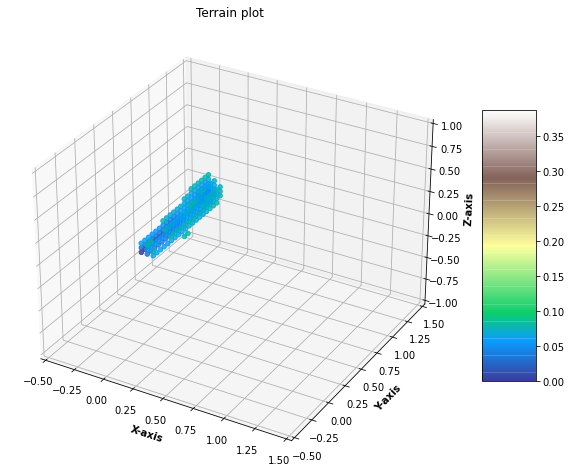

plot_3D


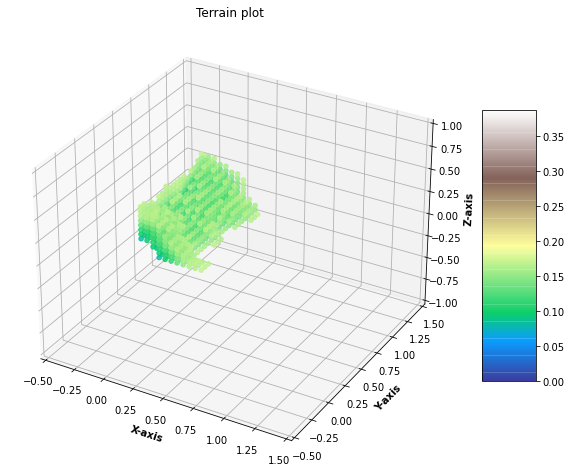

plot_3D


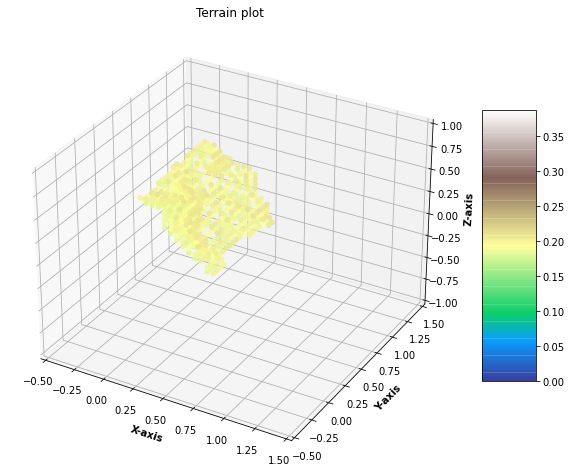

plot_3D


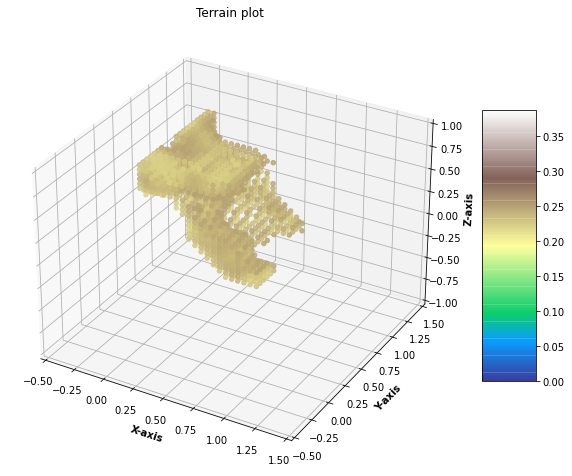

plot_3D


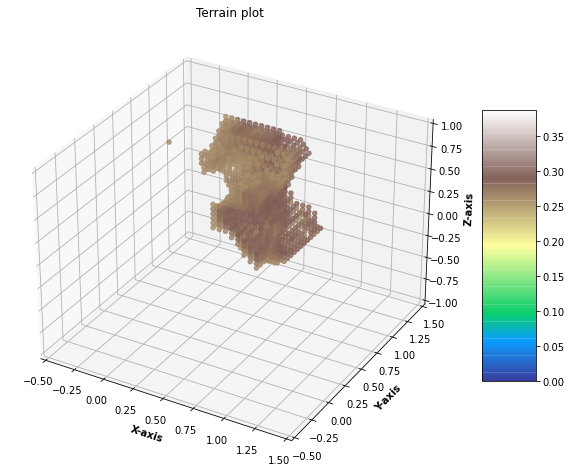

plot_3D


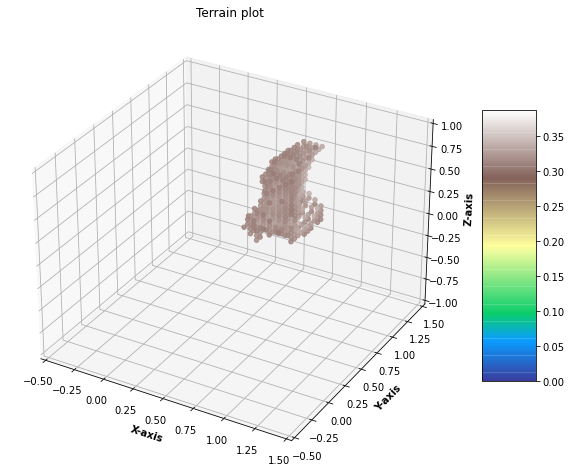

plot_3D


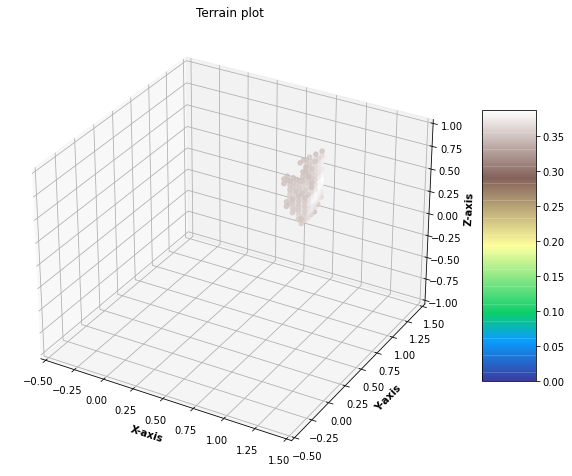

In [58]:
internalValues = [[0.00,0.081], [0.082,0.17], [0.18,0.21], [0.22,0.25], [0.26,0.30], [0.31,0.34], [0.35,0.4]]
for internalValue in internalValues:
    plot_3D(dataframe['x'], dataframe['y'], dataframe['z'], dataframe['density'], internalValue)

plot_3D


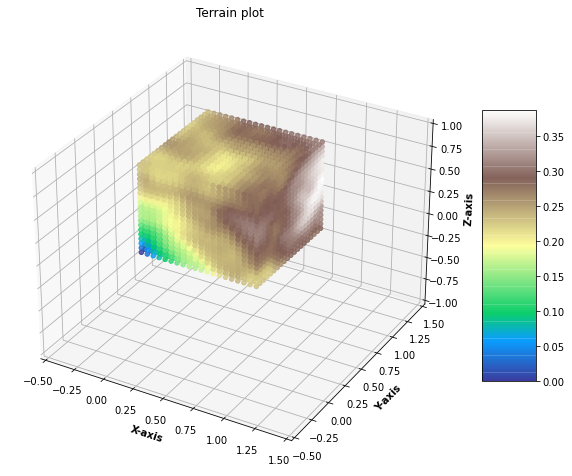

In [106]:
plot_3D(dataframe['x'], dataframe['y'], dataframe['z'], dataframe['density'])